In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error


# Importacion Gasolina Regular

In [152]:
df_imp = pd.read_csv('./data/importacion.csv', parse_dates=['Fecha'], dayfirst=True)
df_imp.set_index('Fecha', inplace=True)
ts_imp_reg = df_imp['Gasolina regular']

ts_imp_reg.head()

Fecha
2001-01-01    177776.50
2001-01-02    123115.99
2001-01-03    161726.42
2001-01-04    127338.74
2001-01-05    168730.19
Name: Gasolina regular, dtype: float64

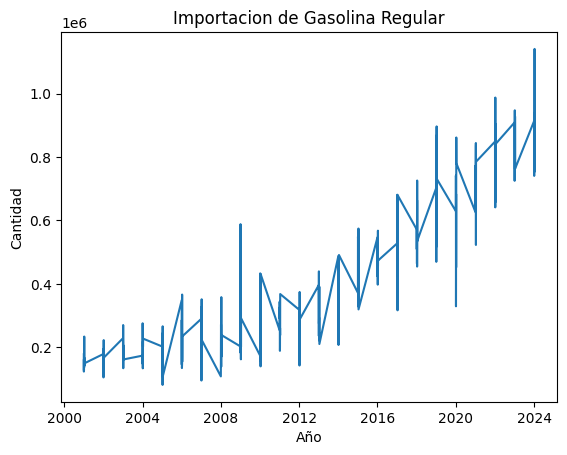

In [153]:
plt.plot(ts_imp_reg)
plt.gca().set(title="Importacion de Gasolina Regular", xlabel="Año", ylabel="Cantidad")
plt.show()

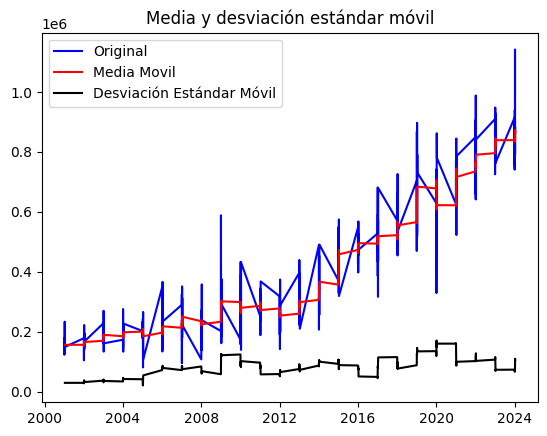

In [154]:
mediaMovil = ts_imp_reg.rolling(window=12).mean()
deMovil = ts_imp_reg.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(ts_imp_reg, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

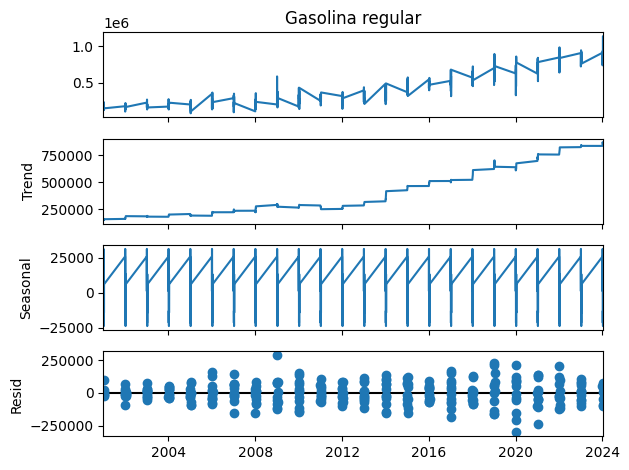

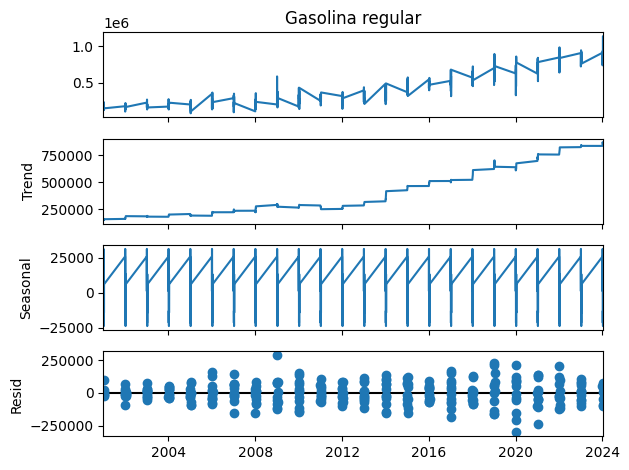

In [155]:
descomposicion = seasonal_decompose(ts_imp_reg, period=12)
descomposicion.plot()

In [156]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(ts_imp_reg, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          0.830167
p-value                        0.992108
# de retardos usados           9.000000
# de observaciones usadas    278.000000
Critical Value (1%)           -3.454094
Critical Value (5%)           -2.871993
Critical Value (10%)          -2.572340
dtype: float64


In [157]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_imp_reg_diff = ts_imp_reg.diff()
ts_imp_reg_diff.fillna(0,inplace=True)
dfTest = adfuller(ts_imp_reg_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -1.023316e+01
p-value                      4.967668e-18
# de retardos usados         8.000000e+00
# de observaciones usadas    2.790000e+02
Critical Value (1%)         -3.454008e+00
Critical Value (5%)         -2.871956e+00
Critical Value (10%)        -2.572320e+00
dtype: float64


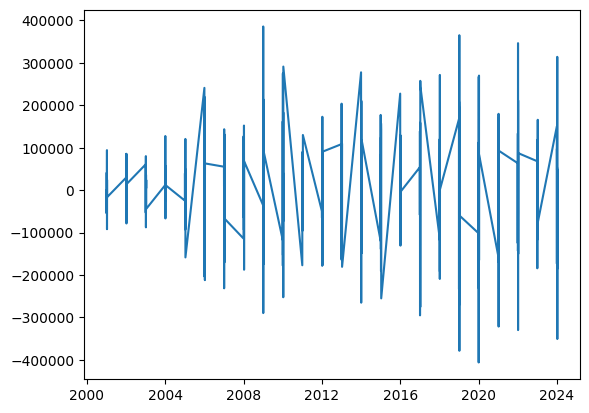

In [158]:
plt.plot(ts_imp_reg_diff)

In [159]:
scaler = StandardScaler()

# Opción A: reshape de la Series
arr = ts_imp_reg_diff.values.reshape(-1, 1)           # (n,1)
scaled_arr = scaler.fit_transform(arr)                # sigue siendo (n,1)
ts_imp_reg_diff_scaled = pd.Series(
    scaled_arr.flatten(), 
    index=ts_imp_reg_diff.index,
    name='diff_scaled'
)

ts_imp_reg_diff_scaled[1:7]

Fecha
2001-01-02   -0.418384
2001-01-03    0.265049
2001-01-04   -0.269837
2001-01-05    0.285427
2001-01-06   -0.133866
2001-01-07   -0.139499
Name: diff_scaled, dtype: float64

## Entrenamiento

In [160]:
total_len = len(ts_imp_reg_diff_scaled)

# Definir proporciones
train_prop = 0.6
val_prop = 0.2
test_prop = 0.2 

# Calcular índices
train_end = int(train_prop * total_len)
val_end = train_end + int(val_prop * total_len)

# Separar sin solapamientos
train = ts_imp_reg_diff_scaled[:train_end]
validation = ts_imp_reg_diff_scaled[train_end:val_end]
test = ts_imp_reg_diff_scaled[val_end:]

train = train.to_numpy().reshape(-1, 1)
validation = validation.to_numpy().reshape(-1, 1)
test = test.to_numpy().reshape(-1, 1)

# Si hace falta, redimensionar (por ejemplo para un LSTM univariante)
train = train.reshape(-1, 1)
validation = validation.reshape(-1, 1)
test = test.reshape(-1, 1)

# Verificar tamaños
print(f"Total registros: {total_len}")
print(f"Train: {len(train)} | Validation: {len(validation)} | Test: {len(test)}")

Total registros: 288
Train: 172 | Validation: 57 | Test: 59


In [161]:
train, type(train)

(array([[-0.01786488],
        [-0.41838396],
        [ 0.26504895],
        [-0.26983695],
        [ 0.28542658],
        [-0.13386558],
        [-0.13949932],
        [ 0.00460047],
        [ 0.67295214],
        [-0.69267044],
        [ 0.1601266 ],
        [-0.13967393],
        [ 0.19732793],
        [-0.26801243],
        [-0.30930178],
        [ 0.60983895],
        [ 0.01504318],
        [-0.44123656],
        [ 0.60758094],
        [-0.59389328],
        [ 0.07857755],
        [ 0.26401923],
        [-0.32738205],
        [ 0.08773027],
        [ 0.42670855],
        [-0.11882757],
        [-0.40792564],
        [ 0.19145981],
        [ 0.56947678],
        [-0.66067977],
        [-0.37387385],
        [ 0.24764807],
        [ 0.03572526],
        [ 0.01474566],
        [ 0.15767056],
        [-0.34134257],
        [ 0.06969381],
        [-0.20462549],
        [ 0.91711167],
        [-0.24049338],
        [-0.50710426],
        [-0.34794052],
        [ 0.11941201],
        [ 0

In [162]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)

In [163]:
x_train

array([[-0.01786488],
       [-0.41838396],
       [ 0.26504895],
       [-0.26983695],
       [ 0.28542658],
       [-0.13386558],
       [-0.13949932],
       [ 0.00460047],
       [ 0.67295214],
       [-0.69267044],
       [ 0.1601266 ],
       [-0.13967393],
       [ 0.19732793],
       [-0.26801243],
       [-0.30930178],
       [ 0.60983895],
       [ 0.01504318],
       [-0.44123656],
       [ 0.60758094],
       [-0.59389328],
       [ 0.07857755],
       [ 0.26401923],
       [-0.32738205],
       [ 0.08773027],
       [ 0.42670855],
       [-0.11882757],
       [-0.40792564],
       [ 0.19145981],
       [ 0.56947678],
       [-0.66067977],
       [-0.37387385],
       [ 0.24764807],
       [ 0.03572526],
       [ 0.01474566],
       [ 0.15767056],
       [-0.34134257],
       [ 0.06969381],
       [-0.20462549],
       [ 0.91711167],
       [-0.24049338],
       [-0.50710426],
       [-0.34794052],
       [ 0.11941201],
       [ 0.39625817],
       [ 0.05472314],
       [-0

In [164]:
y_train, type(y_train)

(array([-0.41838396,  0.26504895, -0.26983695,  0.28542658, -0.13386558,
        -0.13949932,  0.00460047,  0.67295214, -0.69267044,  0.1601266 ,
        -0.13967393,  0.19732793, -0.26801243, -0.30930178,  0.60983895,
         0.01504318, -0.44123656,  0.60758094, -0.59389328,  0.07857755,
         0.26401923, -0.32738205,  0.08773027,  0.42670855, -0.11882757,
        -0.40792564,  0.19145981,  0.56947678, -0.66067977, -0.37387385,
         0.24764807,  0.03572526,  0.01474566,  0.15767056, -0.34134257,
         0.06969381, -0.20462549,  0.91711167, -0.24049338, -0.50710426,
        -0.34794052,  0.11941201,  0.39625817,  0.05472314, -0.13943784,
         0.08421048,  0.06461512, -0.19900084, -0.19569787,  0.27202858,
         0.10541369, -0.32383948,  0.35296925, -0.51171202, -0.0335156 ,
        -0.69781097,  0.45336238,  0.86649821, -1.18031465,  1.74898848,
        -1.50866454,  1.01335625, -0.36194932, -0.78440047,  0.54891226,
        -0.24223378, -0.26477379,  1.58645539, -1.5

## Crear dos modelos

In [165]:
(x_train.shape[0],1,1)

(171, 1, 1)

In [166]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

56

### Primer Modelo

In [167]:
unidades =  10
paso = 1 # lags, 1 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo1 = Sequential()
modelo1.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

modelo1.add(Dense(1))
modelo1.summary()

c:\Users\thiag\Universidad\time_series\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

In [168]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

In [169]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3983 - val_loss: 1.3270
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3451 - val_loss: 1.1333
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3075 - val_loss: 0.9865
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2822 - val_loss: 0.8827
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2675 - val_loss: 0.8154
Epoch 6/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2607 - val_loss: 0.7756
Epoch 7/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2585 - val_loss: 0.7533
Epoch 8/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2585 - val_loss: 0.7410
Epoch 9/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2591 - val_loss: 0.7339
Epoch 10/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2597 - val_loss: 0.7298
Epoch 11/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2601 - val_loss: 0.7273
Epoch 12/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

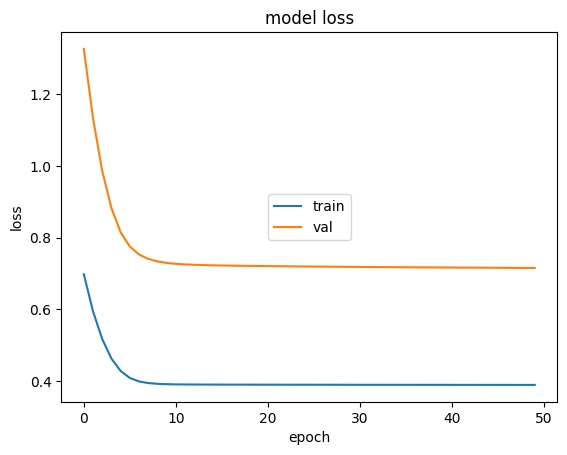

In [170]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [171]:
print("Pérdida en Train")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3047  
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6437
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1248


1.0267338752746582

In [172]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n=train_end)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n = len(ts_imp_reg.values) - len(x_test))


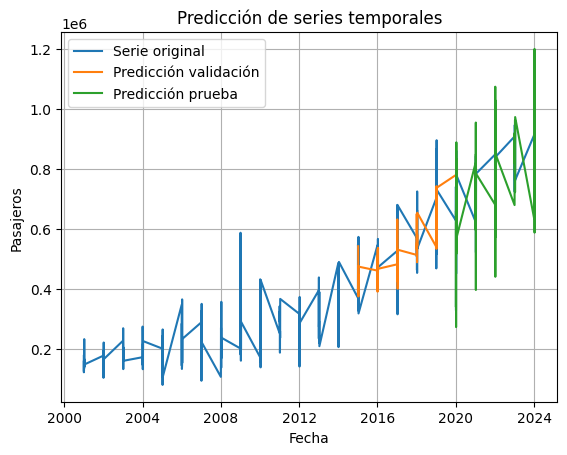

In [173]:
df_val = pd.DataFrame(prediccion_val, index=ts_imp_reg[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test, index=ts_imp_reg[val_end:].index[:len(prediccion_test)])


plt.plot(ts_imp_reg, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.grid(True)
plt.show()

### Segundo Modelo

In [174]:
unidades =  32 #Más neuronas ayuda a modelar patrones complejos
paso = 3 # lags, 3 meses. 
caracteristicas = 1 # es univariada
lote = 16 # Un batch mayor suele estabilizar gradientes y acelerar el entrenamiento en GPU/CPU modernas.


modelo2 = Sequential()
modelo2.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

modelo2.add(Dense(1))
modelo2.summary()

c:\Users\thiag\Universidad\time_series\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [175]:
modelo2.compile(loss='mean_squared_error',optimizer="ADAM")

In [176]:
from tensorflow.keras.callbacks import EarlyStopping

# Evita overfitting
es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1       
)

epocas = 100
history = modelo2.fit(
    x=x_train,
    y=y_train,
    batch_size=lote,
    epochs=epocas,
    shuffle=False,
    validation_data=(x_val, y_val),
    callbacks=[es],
    verbose=1
)

best_val_loss = min(history.history['val_loss'])
best_epoch = history.history['val_loss'].index(best_val_loss) + 1

print(f"\nEntrenamiento detenido en la época {es.stopped_epoch+1} de {epocas} "
      f"porque val_loss no mejoró durante {es.patience} épocas.")
print(f"   • Mejor val_loss = {best_val_loss:.4f} en la época {best_epoch}.")

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.4395 - val_loss: 1.4140
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4286 - val_loss: 1.3739
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4183 - val_loss: 1.3351
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4085 - val_loss: 1.2975
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3990 - val_loss: 1.2606
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3897 - val_loss: 1.2243
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3806 - val_loss: 1.1881
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3715 - val_loss: 1.1521
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3625 - val_loss: 1.1162
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3536 - val_loss: 1.0805
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3450 - val_loss: 1.0452
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.

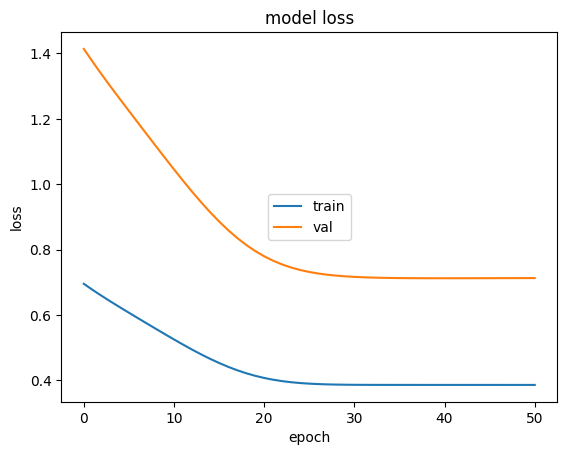

In [177]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [178]:
print("Pérdida en Train")
modelo2.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo2.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3048 
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6413
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1205


1.022825002670288

In [179]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo2.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


prediccion_val = prediccion_fun(x_val,modelo2, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n=train_end)
prediccion_test = prediccion_fun(x_test,modelo2, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n = len(ts_imp_reg.values) - len(x_test))


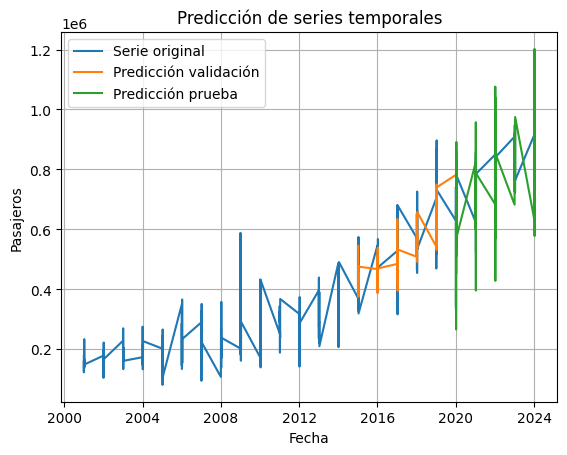

In [180]:
df_val = pd.DataFrame(prediccion_val, index=ts_imp_reg[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test, index=ts_imp_reg[val_end:].index[:len(prediccion_test)])


plt.plot(ts_imp_reg, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.grid(True)
plt.show()

# Consumo Gasolina Regular

In [181]:
df_imp = pd.read_csv('./data/consumo.csv', parse_dates=['Fecha'], dayfirst=True)
df_imp.set_index('Fecha', inplace=True)
ts_imp_reg = df_imp['Gasolina regular']

ts_imp_reg.head()

Fecha
2000-01-01    202645.20
2000-01-02    205530.96
2000-01-03    229499.56
2000-01-04    210680.40
2000-01-05    208164.34
Name: Gasolina regular, dtype: float64

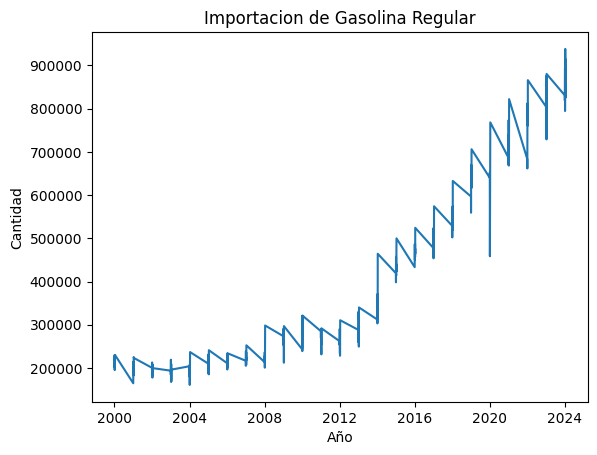

In [182]:
plt.plot(ts_imp_reg)
plt.gca().set(title="Importacion de Gasolina Regular", xlabel="Año", ylabel="Cantidad")
plt.show()

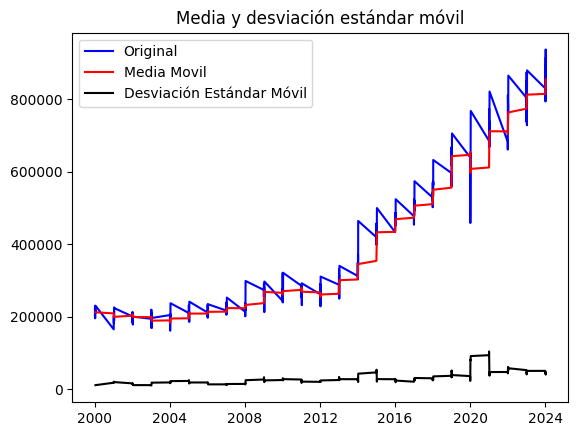

In [183]:
mediaMovil = ts_imp_reg.rolling(window=12).mean()
deMovil = ts_imp_reg.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(ts_imp_reg, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

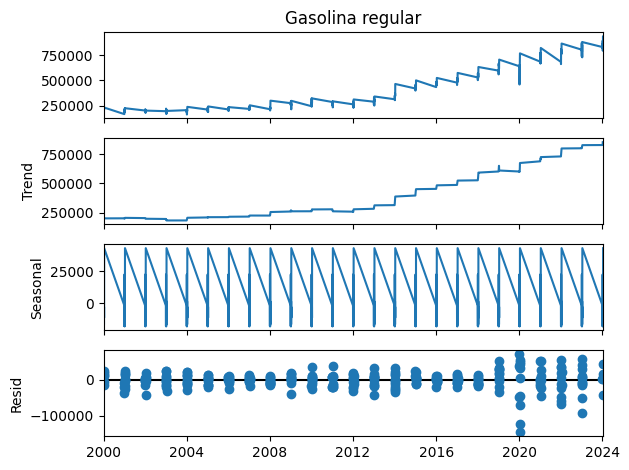

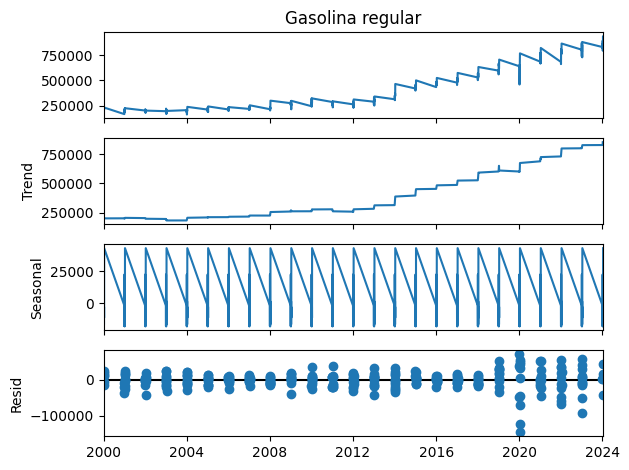

In [184]:
descomposicion = seasonal_decompose(ts_imp_reg, period=12)
descomposicion.plot()

In [185]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(ts_imp_reg, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          2.478789
p-value                        0.999043
# de retardos usados          14.000000
# de observaciones usadas    285.000000
Critical Value (1%)           -3.453505
Critical Value (5%)           -2.871735
Critical Value (10%)          -2.572202
dtype: float64


In [186]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_imp_reg_diff = ts_imp_reg.diff()
ts_imp_reg_diff.fillna(0,inplace=True)
dfTest = adfuller(ts_imp_reg_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -4.372644
p-value                        0.000332
# de retardos usados          16.000000
# de observaciones usadas    283.000000
Critical Value (1%)           -3.453670
Critical Value (5%)           -2.871808
Critical Value (10%)          -2.572241
dtype: float64


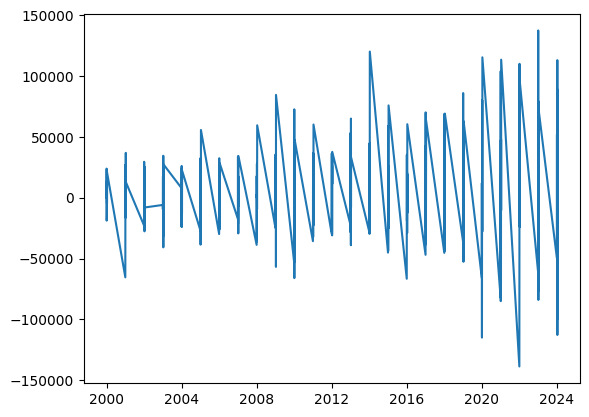

In [187]:
plt.plot(ts_imp_reg_diff)

In [188]:
scaler = StandardScaler()

# Opción A: reshape de la Series
arr = ts_imp_reg_diff.values.reshape(-1, 1)           # (n,1)
scaled_arr = scaler.fit_transform(arr)                # sigue siendo (n,1)
ts_imp_reg_diff_scaled = pd.Series(
    scaled_arr.flatten(), 
    index=ts_imp_reg_diff.index,
    name='diff_scaled'
)

ts_imp_reg_diff_scaled[1:7]

Fecha
2000-01-02    0.012832
2000-01-03    0.538373
2000-01-04   -0.528216
2000-01-05   -0.121822
2000-01-06   -0.385044
2000-01-07    0.176911
Name: diff_scaled, dtype: float64

## Entrenamiento

In [189]:
total_len = len(ts_imp_reg_diff_scaled)

# Definir proporciones
train_prop = 0.6
val_prop = 0.2
test_prop = 0.2 

# Calcular índices
train_end = int(train_prop * total_len)
val_end = train_end + int(val_prop * total_len)

# Separar sin solapamientos
train = ts_imp_reg_diff_scaled[:train_end]
validation = ts_imp_reg_diff_scaled[train_end:val_end]
test = ts_imp_reg_diff_scaled[val_end:]

train = train.to_numpy().reshape(-1, 1)
validation = validation.to_numpy().reshape(-1, 1)
test = test.to_numpy().reshape(-1, 1)

# Si hace falta, redimensionar (por ejemplo para un LSTM univariante)
train = train.reshape(-1, 1)
validation = validation.reshape(-1, 1)
test = test.reshape(-1, 1)

# Verificar tamaños
print(f"Total registros: {total_len}")
print(f"Train: {len(train)} | Validation: {len(validation)} | Test: {len(test)}")

Total registros: 300
Train: 180 | Validation: 60 | Test: 60


In [190]:
train, type(train)

(array([[-5.91026109e-02],
        [ 1.28320202e-02],
        [ 5.38373409e-01],
        [-5.28216235e-01],
        [-1.21821565e-01],
        [-3.85043944e-01],
        [ 1.76911211e-01],
        [ 2.85687363e-01],
        [-1.70816214e-01],
        [-6.65885727e-02],
        [-1.68264142e-01],
        [ 4.59219291e-01],
        [-1.69118607e+00],
        [ 1.97437219e-01],
        [ 6.17773312e-01],
        [-1.41594016e-01],
        [-4.62411264e-01],
        [ 4.11412684e-01],
        [ 2.79929621e-01],
        [-3.16689643e-01],
        [-4.66776558e-01],
        [ 8.61931679e-01],
        [-4.30920419e-01],
        [ 2.62087551e-01],
        [-6.29943653e-01],
        [-4.87618148e-01],
        [ 6.78559641e-01],
        [-2.57178353e-01],
        [-1.50888215e-01],
        [-3.94478734e-01],
        [ 2.91457568e-01],
        [ 2.93432136e-02],
        [-7.47747530e-01],
        [ 5.76109576e-01],
        [ 5.38827901e-02],
        [-2.58784927e-01],
        [-2.06315433e-01],
 

In [191]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)

In [192]:
x_train

array([[-5.91026109e-02],
       [ 1.28320202e-02],
       [ 5.38373409e-01],
       [-5.28216235e-01],
       [-1.21821565e-01],
       [-3.85043944e-01],
       [ 1.76911211e-01],
       [ 2.85687363e-01],
       [-1.70816214e-01],
       [-6.65885727e-02],
       [-1.68264142e-01],
       [ 4.59219291e-01],
       [-1.69118607e+00],
       [ 1.97437219e-01],
       [ 6.17773312e-01],
       [-1.41594016e-01],
       [-4.62411264e-01],
       [ 4.11412684e-01],
       [ 2.79929621e-01],
       [-3.16689643e-01],
       [-4.66776558e-01],
       [ 8.61931679e-01],
       [-4.30920419e-01],
       [ 2.62087551e-01],
       [-6.29943653e-01],
       [-4.87618148e-01],
       [ 6.78559641e-01],
       [-2.57178353e-01],
       [-1.50888215e-01],
       [-3.94478734e-01],
       [ 2.91457568e-01],
       [ 2.93432136e-02],
       [-7.47747530e-01],
       [ 5.76109576e-01],
       [ 5.38827901e-02],
       [-2.58784927e-01],
       [-2.06315433e-01],
       [-2.92398842e-01],
       [ 3.6

In [193]:
y_train, type(y_train)

(array([ 1.28320202e-02,  5.38373409e-01, -5.28216235e-01, -1.21821565e-01,
        -3.85043944e-01,  1.76911211e-01,  2.85687363e-01, -1.70816214e-01,
        -6.65885727e-02, -1.68264142e-01,  4.59219291e-01, -1.69118607e+00,
         1.97437219e-01,  6.17773312e-01, -1.41594016e-01, -4.62411264e-01,
         4.11412684e-01,  2.79929621e-01, -3.16689643e-01, -4.66776558e-01,
         8.61931679e-01, -4.30920419e-01,  2.62087551e-01, -6.29943653e-01,
        -4.87618148e-01,  6.78559641e-01, -2.57178353e-01, -1.50888215e-01,
        -3.94478734e-01,  2.91457568e-01,  2.93432136e-02, -7.47747530e-01,
         5.76109576e-01,  5.38827901e-02, -2.58784927e-01, -2.06315433e-01,
        -2.92398842e-01,  3.66876558e-01,  3.78646863e-01, -5.22681656e-01,
        -8.58761668e-01,  9.02090609e-02, -1.25223164e-01,  1.79954917e-02,
         8.02302731e-01, -1.07625340e+00,  6.28196724e-01,  1.37664191e-01,
        -6.49517433e-01,  5.93133527e-01, -6.59248361e-01, -5.98483220e-01,
         4.1

## Crear dos modelos

In [194]:
(x_train.shape[0],1,1)

(179, 1, 1)

In [195]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

59

### Primer Modelo

In [196]:
unidades =  10
paso = 1 # lags, 1 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo1 = Sequential()
modelo1.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

modelo1.add(Dense(1))
modelo1.summary()

c:\Users\thiag\Universidad\time_series\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

In [197]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

In [198]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3099 - val_loss: 0.8490
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2849 - val_loss: 0.7712
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2700 - val_loss: 0.7185
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2615 - val_loss: 0.6844
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2571 - val_loss: 0.6626
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2550 - val_loss: 0.6488
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2539 - val_loss: 0.6400
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2533 - val_loss: 0.6343
Epoch 9/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2529 - val_loss: 0.6305
Epoch 10/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2526 - val_loss: 0.6278
Epoch 11/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2522 - val_loss: 0.6260
Epoch 12/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

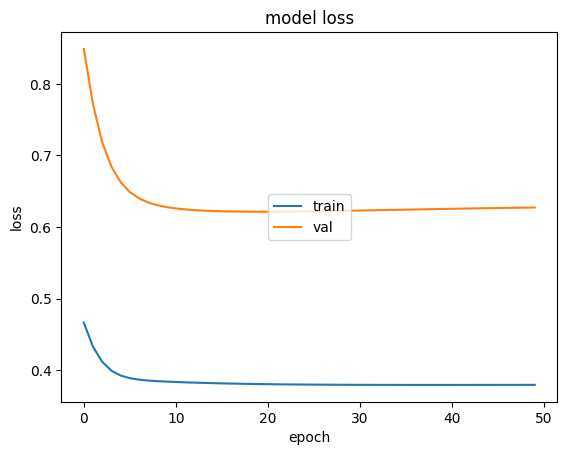

In [199]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [200]:
print("Pérdida en Train")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2927  
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5762
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.1906


2.2202279567718506

In [201]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n=train_end)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n = len(ts_imp_reg.values) - len(x_test))


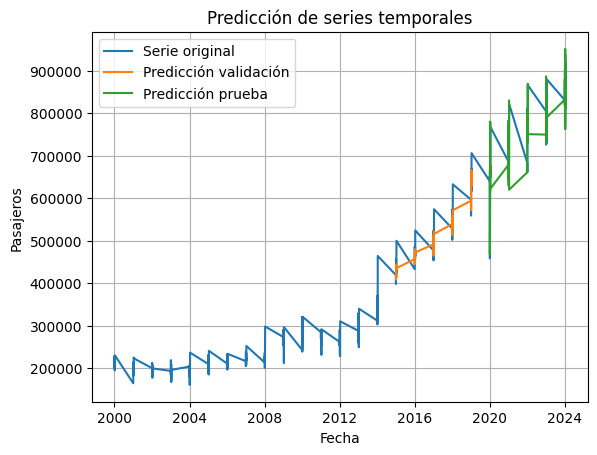

In [202]:
df_val = pd.DataFrame(prediccion_val, index=ts_imp_reg[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test, index=ts_imp_reg[val_end:].index[:len(prediccion_test)])


plt.plot(ts_imp_reg, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.grid(True)
plt.show()

### Segundo Modelo

In [203]:
unidades =  32 #Más neuronas ayuda a modelar patrones complejos
paso = 3 # lags, 3 meses. 
caracteristicas = 1 # es univariada
lote = 16 # Un batch mayor suele estabilizar gradientes y acelerar el entrenamiento en GPU/CPU modernas.


modelo2 = Sequential()
modelo2.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

modelo2.add(Dense(1))
modelo2.summary()

c:\Users\thiag\Universidad\time_series\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [204]:
modelo2.compile(loss='mean_squared_error',optimizer="ADAM")

In [205]:
from tensorflow.keras.callbacks import EarlyStopping

# Evita overfitting
es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1       
)

epocas = 100
history = modelo2.fit(
    x=x_train,
    y=y_train,
    batch_size=lote,
    epochs=epocas,
    shuffle=False,
    validation_data=(x_val, y_val),
    callbacks=[es],
    verbose=1
)

best_val_loss = min(history.history['val_loss'])
best_epoch = history.history['val_loss'].index(best_val_loss) + 1

print(f"\nEntrenamiento detenido en la época {es.stopped_epoch+1} de {epocas} "
      f"porque val_loss no mejoró durante {es.patience} épocas.")
print(f"   • Mejor val_loss = {best_val_loss:.4f} en la época {best_epoch}.")

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.3352 - val_loss: 0.8604
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3258 - val_loss: 0.8311
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3195 - val_loss: 0.8041
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3140 - val_loss: 0.7794
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3093 - val_loss: 0.7569
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3051 - val_loss: 0.7363
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3015 - val_loss: 0.7176
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2983 - val_loss: 0.7006
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2956 - val_loss: 0.6853
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2933 - val_loss: 0.6718
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2914 - val_loss: 0.6601
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.

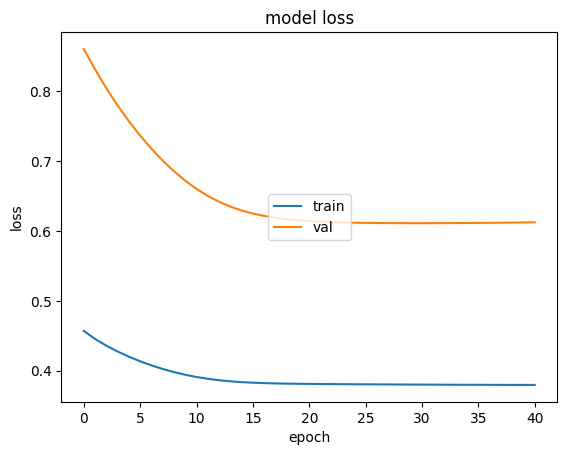

In [206]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [207]:
print("Pérdida en Train")
modelo2.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo2.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2993 
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5664
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.1588


2.1546361446380615

In [208]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo2.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


prediccion_val = prediccion_fun(x_val,modelo2, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n=train_end)
prediccion_test = prediccion_fun(x_test,modelo2, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n = len(ts_imp_reg.values) - len(x_test))


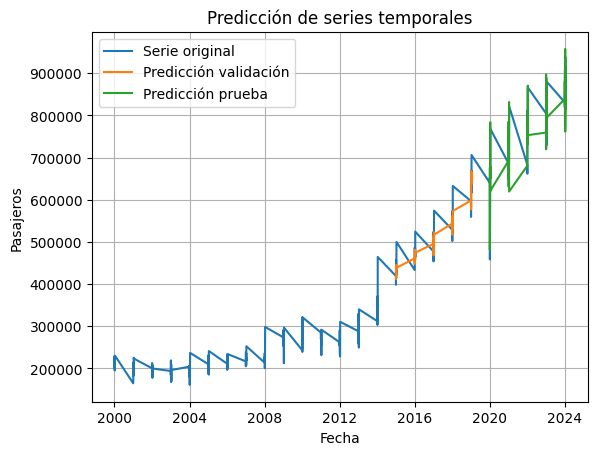

In [209]:
df_val = pd.DataFrame(prediccion_val, index=ts_imp_reg[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test, index=ts_imp_reg[val_end:].index[:len(prediccion_test)])


plt.plot(ts_imp_reg, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.grid(True)
plt.show()

# Importacion Gasolina Superior

In [210]:
df_imp = pd.read_csv('./data/importacion.csv', parse_dates=['Fecha'], dayfirst=True)
df_imp.set_index('Fecha', inplace=True)
ts_imp_reg = df_imp['Gasolina superior']

ts_imp_reg.head()

Fecha
2001-01-01    373963.96
2001-01-02    243091.07
2001-01-03    312084.38
2001-01-04    285054.89
2001-01-05    300913.67
Name: Gasolina superior, dtype: float64

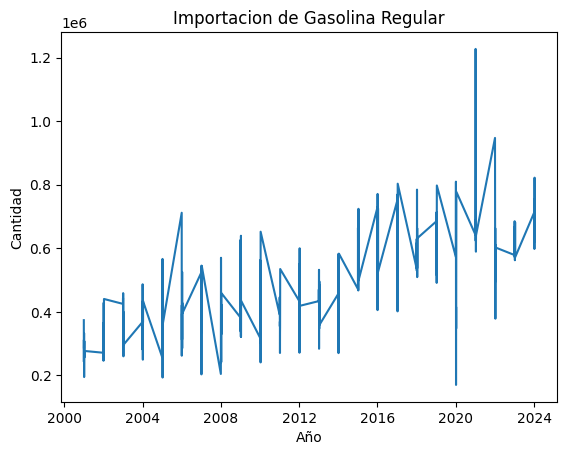

In [211]:
plt.plot(ts_imp_reg)
plt.gca().set(title="Importacion de Gasolina Regular", xlabel="Año", ylabel="Cantidad")
plt.show()

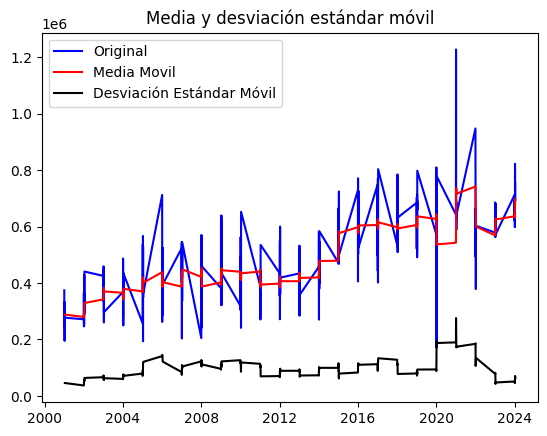

In [212]:
mediaMovil = ts_imp_reg.rolling(window=12).mean()
deMovil = ts_imp_reg.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(ts_imp_reg, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

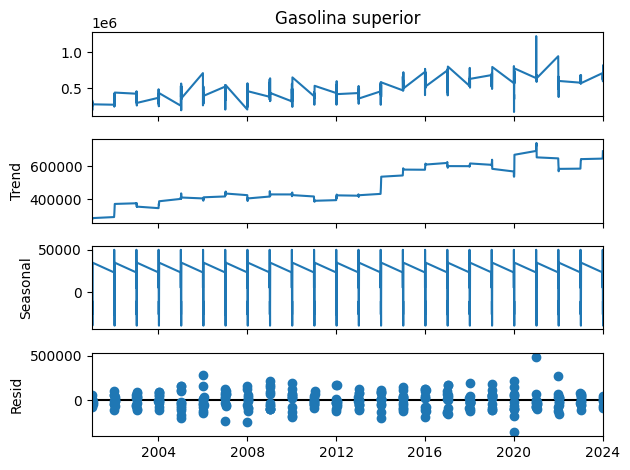

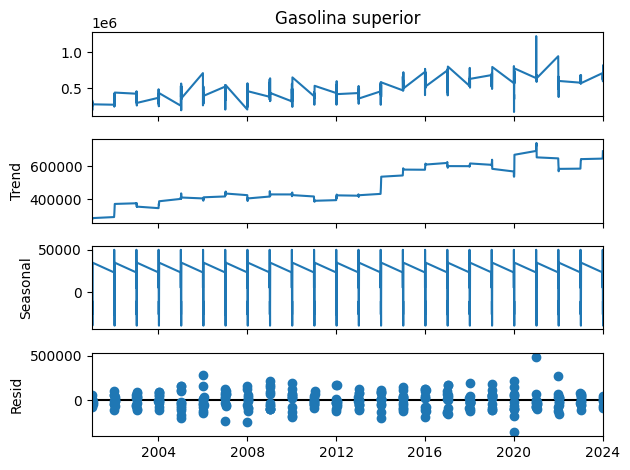

In [213]:
descomposicion = seasonal_decompose(ts_imp_reg, period=12)
descomposicion.plot()

In [214]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(ts_imp_reg, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -1.601987
p-value                        0.482595
# de retardos usados           9.000000
# de observaciones usadas    278.000000
Critical Value (1%)           -3.454094
Critical Value (5%)           -2.871993
Critical Value (10%)          -2.572340
dtype: float64


In [215]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_imp_reg_diff = ts_imp_reg.diff()
ts_imp_reg_diff.fillna(0,inplace=True)
dfTest = adfuller(ts_imp_reg_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -7.800177e+00
p-value                      7.529848e-12
# de retardos usados         1.100000e+01
# de observaciones usadas    2.760000e+02
Critical Value (1%)         -3.454267e+00
Critical Value (5%)         -2.872070e+00
Critical Value (10%)        -2.572381e+00
dtype: float64


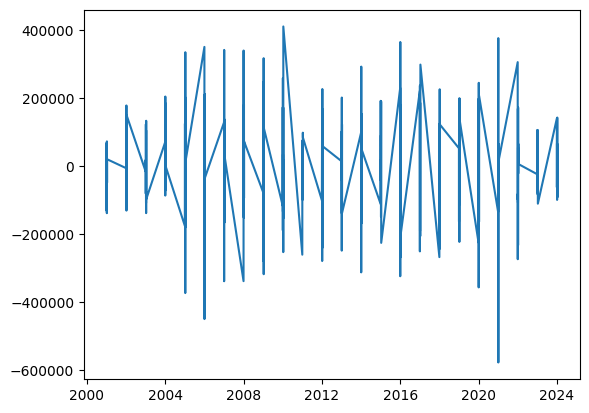

In [216]:
plt.plot(ts_imp_reg_diff)

In [217]:
scaler = StandardScaler()

# Opción A: reshape de la Series
arr = ts_imp_reg_diff.values.reshape(-1, 1)           # (n,1)
scaled_arr = scaler.fit_transform(arr)                # sigue siendo (n,1)
ts_imp_reg_diff_scaled = pd.Series(
    scaled_arr.flatten(), 
    index=ts_imp_reg_diff.index,
    name='diff_scaled'
)

ts_imp_reg_diff_scaled[1:7]

Fecha
2001-01-02   -0.840516
2001-01-03    0.430275
2001-01-04   -0.180258
2001-01-05    0.092435
2001-01-06    0.196994
2001-01-07   -0.886755
Name: diff_scaled, dtype: float64

## Entrenamiento

In [218]:
total_len = len(ts_imp_reg_diff_scaled)

# Definir proporciones
train_prop = 0.6
val_prop = 0.2
test_prop = 0.2 

# Calcular índices
train_end = int(train_prop * total_len)
val_end = train_end + int(val_prop * total_len)

# Separar sin solapamientos
train = ts_imp_reg_diff_scaled[:train_end]
validation = ts_imp_reg_diff_scaled[train_end:val_end]
test = ts_imp_reg_diff_scaled[val_end:]

train = train.to_numpy().reshape(-1, 1)
validation = validation.to_numpy().reshape(-1, 1)
test = test.to_numpy().reshape(-1, 1)

# Si hace falta, redimensionar (por ejemplo para un LSTM univariante)
train = train.reshape(-1, 1)
validation = validation.reshape(-1, 1)
test = test.reshape(-1, 1)

# Verificar tamaños
print(f"Total registros: {total_len}")
print(f"Train: {len(train)} | Validation: {len(validation)} | Test: {len(test)}")

Total registros: 288
Train: 172 | Validation: 57 | Test: 59


In [219]:
train, type(train)

(array([[-0.00839873],
        [-0.84051577],
        [ 0.43027508],
        [-0.18025785],
        [ 0.09243469],
        [ 0.19699376],
        [-0.88675546],
        [ 0.456268  ],
        [ 0.24774682],
        [-0.02961474],
        [-0.31654349],
        [ 0.12198815],
        [-0.04442466],
        [ 0.59040934],
        [-0.76734717],
        [ 0.39829577],
        [ 0.32893891],
        [-0.72807519],
        [ 1.1279377 ],
        [-0.83854206],
        [ 0.19998117],
        [ 0.12513508],
        [-0.39540212],
        [ 0.94208373],
        [-0.10690206],
        [ 0.11027309],
        [-0.5202166 ],
        [-0.18584341],
        [ 0.77735496],
        [-0.5586327 ],
        [ 0.17240607],
        [-0.69863262],
        [ 0.6644721 ],
        [-0.88565492],
        [ 0.84189738],
        [-0.6262373 ],
        [ 0.44592695],
        [-0.55738656],
        [ 1.29496299],
        [-0.46272333],
        [-0.42405417],
        [-0.25519219],
        [-0.39960224],
        [ 1

In [220]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)

In [221]:
x_train

array([[-0.00839873],
       [-0.84051577],
       [ 0.43027508],
       [-0.18025785],
       [ 0.09243469],
       [ 0.19699376],
       [-0.88675546],
       [ 0.456268  ],
       [ 0.24774682],
       [-0.02961474],
       [-0.31654349],
       [ 0.12198815],
       [-0.04442466],
       [ 0.59040934],
       [-0.76734717],
       [ 0.39829577],
       [ 0.32893891],
       [-0.72807519],
       [ 1.1279377 ],
       [-0.83854206],
       [ 0.19998117],
       [ 0.12513508],
       [-0.39540212],
       [ 0.94208373],
       [-0.10690206],
       [ 0.11027309],
       [-0.5202166 ],
       [-0.18584341],
       [ 0.77735496],
       [-0.5586327 ],
       [ 0.17240607],
       [-0.69863262],
       [ 0.6644721 ],
       [-0.88565492],
       [ 0.84189738],
       [-0.6262373 ],
       [ 0.44592695],
       [-0.55738656],
       [ 1.29496299],
       [-0.46272333],
       [-0.42405417],
       [-0.25519219],
       [-0.39960224],
       [ 1.16702684],
       [-0.09759059],
       [-0

In [222]:
y_train, type(y_train)

(array([-0.84051577,  0.43027508, -0.18025785,  0.09243469,  0.19699376,
        -0.88675546,  0.456268  ,  0.24774682, -0.02961474, -0.31654349,
         0.12198815, -0.04442466,  0.59040934, -0.76734717,  0.39829577,
         0.32893891, -0.72807519,  1.1279377 , -0.83854206,  0.19998117,
         0.12513508, -0.39540212,  0.94208373, -0.10690206,  0.11027309,
        -0.5202166 , -0.18584341,  0.77735496, -0.5586327 ,  0.17240607,
        -0.69863262,  0.6644721 , -0.88565492,  0.84189738, -0.6262373 ,
         0.44592695, -0.55738656,  1.29496299, -0.46272333, -0.42405417,
        -0.25519219, -0.39960224,  1.16702684, -0.09759059, -0.34960554,
         0.42284443, -0.01832377, -1.12287794,  0.30183349,  0.7879504 ,
         0.64168988, -0.99732584,  1.00117106, -1.11464762,  1.28363775,
        -2.3808626 ,  2.12409708, -1.15407963,  0.0686576 ,  2.22367412,
        -2.86762041,  0.91922845,  0.0757552 , -0.70319902,  0.51291169,
        -0.12325143, -0.40657705,  1.34142522, -1.5

## Crear dos modelos

In [223]:
(x_train.shape[0],1,1)

(171, 1, 1)

In [224]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

56

### Primer Modelo

In [225]:
unidades =  10
paso = 1 # lags, 1 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo1 = Sequential()
modelo1.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

modelo1.add(Dense(1))
modelo1.summary()

c:\Users\thiag\Universidad\time_series\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

In [226]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

In [227]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6207 - val_loss: 0.9275
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5337 - val_loss: 0.7770
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4686 - val_loss: 0.6641
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4262 - val_loss: 0.5956
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4051 - val_loss: 0.5607
Epoch 6/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3968 - val_loss: 0.5443
Epoch 7/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3943 - val_loss: 0.5365
Epoch 8/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3937 - val_loss: 0.5325
Epoch 9/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3936 - val_loss: 0.5303
Epoch 10/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3936 - val_loss: 0.5289
Epoch 11/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3936 - val_loss: 0.5279
Epoch 12/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

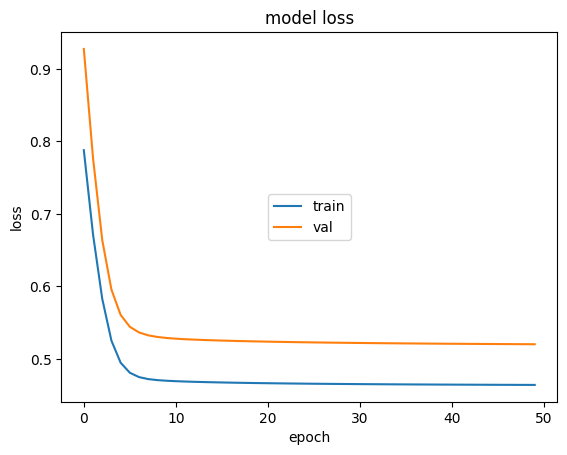

In [228]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [229]:
print("Pérdida en Train")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4234  
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5524
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1289


0.9310991764068604

In [230]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n=train_end)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n = len(ts_imp_reg.values) - len(x_test))


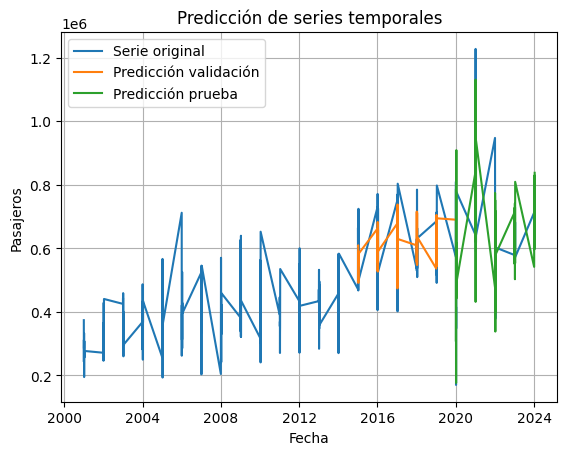

In [231]:
df_val = pd.DataFrame(prediccion_val, index=ts_imp_reg[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test, index=ts_imp_reg[val_end:].index[:len(prediccion_test)])


plt.plot(ts_imp_reg, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.grid(True)
plt.show()

### Segundo Modelo

In [232]:
unidades =  32 #Más neuronas ayuda a modelar patrones complejos
paso = 3 # lags, 3 meses. 
caracteristicas = 1 # es univariada
lote = 16 # Un batch mayor suele estabilizar gradientes y acelerar el entrenamiento en GPU/CPU modernas.


modelo2 = Sequential()
modelo2.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

modelo2.add(Dense(1))
modelo2.summary()

c:\Users\thiag\Universidad\time_series\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [233]:
modelo2.compile(loss='mean_squared_error',optimizer="ADAM")

In [234]:
from tensorflow.keras.callbacks import EarlyStopping

# Evita overfitting
es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1       
)

epocas = 100
history = modelo2.fit(
    x=x_train,
    y=y_train,
    batch_size=lote,
    epochs=epocas,
    shuffle=False,
    validation_data=(x_val, y_val),
    callbacks=[es],
    verbose=1
)

best_val_loss = min(history.history['val_loss'])
best_epoch = history.history['val_loss'].index(best_val_loss) + 1

print(f"\nEntrenamiento detenido en la época {es.stopped_epoch+1} de {epocas} "
      f"porque val_loss no mejoró durante {es.patience} épocas.")
print(f"   • Mejor val_loss = {best_val_loss:.4f} en la época {best_epoch}.")

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.6883 - val_loss: 1.0723
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6626 - val_loss: 1.0268
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6379 - val_loss: 0.9825
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6140 - val_loss: 0.9396
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5910 - val_loss: 0.8978
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5688 - val_loss: 0.8573
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5475 - val_loss: 0.8181
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5271 - val_loss: 0.7804
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5077 - val_loss: 0.7445
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4896 - val_loss: 0.7107
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4728 - val_loss: 0.6793
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss:

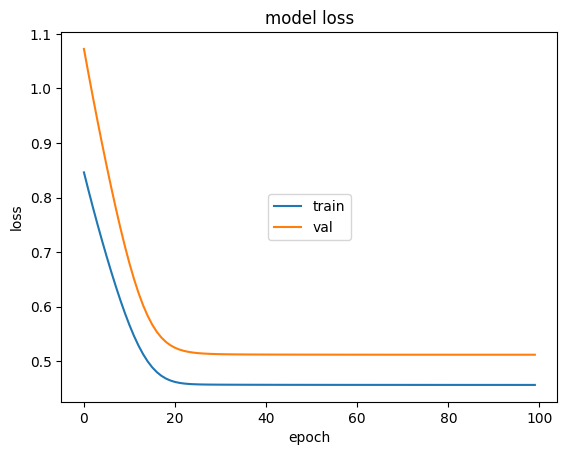

In [235]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [236]:
print("Pérdida en Train")
modelo2.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo2.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4183 
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5407
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1289


0.9292928576469421

In [237]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo2.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


prediccion_val = prediccion_fun(x_val,modelo2, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n=train_end)
prediccion_test = prediccion_fun(x_test,modelo2, 1,scaler,dif=True,dif_cant=1, Series = ts_imp_reg.values , n = len(ts_imp_reg.values) - len(x_test))


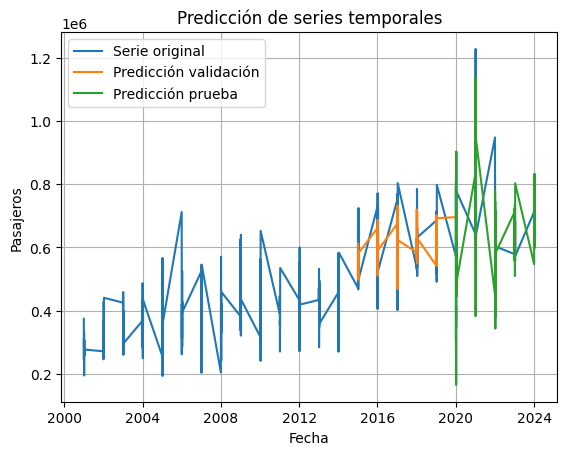

In [238]:
df_val = pd.DataFrame(prediccion_val, index=ts_imp_reg[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test, index=ts_imp_reg[val_end:].index[:len(prediccion_test)])


plt.plot(ts_imp_reg, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.grid(True)
plt.show()

# u